## practice 1 using M prosessing to etrcat airport 

In [2]:
! uv pip install opencv-contrib-python

Using Python 3.12.11 environment at: /Users/saharmohamed/Documents/UBS_Material/IP/.venv
Resolved 2 packages in 464ms                                         
⠙ Preparing packages... (0/2)                                                   
⠙ Preparing packages... (0/2)--------------     0 B/4.85 MiB            
⠙ Preparing packages... (0/2)-------------- 16.00 KiB/4.85 MiB          
⠙ Preparing packages... (0/2)-------------- 32.00 KiB/4.85 MiB          
⠙ Preparing packages... (0/2)-------------- 48.00 KiB/4.85 MiB          
⠙ Preparing packages... (0/2)--------------- 48.00 KiB/4.85 MiB         
numpy                 ------------------------------ 48.00 KiB/4.85 MiB
⠙ Preparing packages... (0/2)---------------     0 B/44.68 MiB          
numpy                 ------------------------------ 61.84 KiB/4.85 MiB
⠙ Preparing packages... (0/2)---------------     0 B/44.68 MiB          
numpy                 ------------------------------ 77.84 KiB/4.85 MiB
⠙ Preparing packages... (0/2)----

In [1]:
import cv2
import numpy as np


# Loading the image
img = cv2.imread('galeao.jpg')

img.shape

(559, 750, 3)

In [2]:
# preprocess the image
gray_img = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
gray_img.shape

(559, 750)

In [ ]:


# Applying 7x7 Gaussian Blur
blurred = cv2.GaussianBlur(gray_img, (7, 7), 0)

# Applying threshold
threshold = cv2.threshold(blurred, 0, 255,
    cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1] 

# Apply the Component analysis function
analysis = cv2.connectedComponentsWithStats(threshold,
                                            4,
                                            cv2.CV_32S)
(totalLabels, label_ids, values, centroid) = analysis

# Initialize a new image to store 
# all the output components
output = np.zeros(gray_img.shape, dtype="uint8")

# Loop through each component
for i in range(1, totalLabels):
  
      # Area of the component
    area = values[i, cv2.CC_STAT_AREA] 
    
    if (area > 200) and (area < 200000):
        componentMask = (label_ids == i).astype("uint8") * 255
        output = cv2.bitwise_or(output, componentMask)


cv2.imshow("Image", img)
cv2.imshow("Filtered Components", output)
cv2.waitKey(0)

In [ ]:
# Applying 7x7 Gaussian Blur
blurred = cv2.GaussianBlur(gray_img, (7, 7), 0)

# Applying threshold
threshold = cv2.threshold(blurred, 0, 255,
    cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1] 

# Apply the Component analysis function
analysis = cv2.connectedComponentsWithStats(threshold, 
                                            4, 
                                            cv2.CV_32S)
(totalLabels, label_ids, values, centroid) = analysis

# Initialize a new image to
# store all the output components
output = np.zeros(gray_img.shape, dtype="uint8")

# Loop through each component
for i in range(1, totalLabels):
  
      # Area of the component
    area = values[i, cv2.CC_STAT_AREA] 
    
    if (area > 140) and (area < 400):
        # Create a new image for bounding boxes
        new_img=img.copy()
        
        # Now extract the coordinate points
        x1 = values[i, cv2.CC_STAT_LEFT]
        y1 = values[i, cv2.CC_STAT_TOP]
        w = values[i, cv2.CC_STAT_WIDTH]
        h = values[i, cv2.CC_STAT_HEIGHT]
        
        # Coordinate of the bounding box
        pt1 = (x1, y1)
        pt2 = (x1+ w, y1+ h)
        (X, Y) = centroid[i]
        
        # Bounding boxes for each component
        cv2.rectangle(new_img,pt1,pt2,
                      (0, 255, 0), 3)
        cv2.circle(new_img, (int(X),
                             int(Y)), 
                   4, (0, 0, 255), -1)

        # Create a new array to show individual component
        component = np.zeros(gray_img.shape, dtype="uint8")
        componentMask = (label_ids == i).astype("uint8") * 255

        # Apply the mask using the bitwise operator
        component = cv2.bitwise_or(component,componentMask)
        output = cv2.bitwise_or(output, componentMask)
        
        # Show the final images
        cv2.imshow("Image", new_img)
        cv2.imshow("Individual Component", component)
        cv2.imshow("Filtered Components", output)
        cv2.waitKey(0)

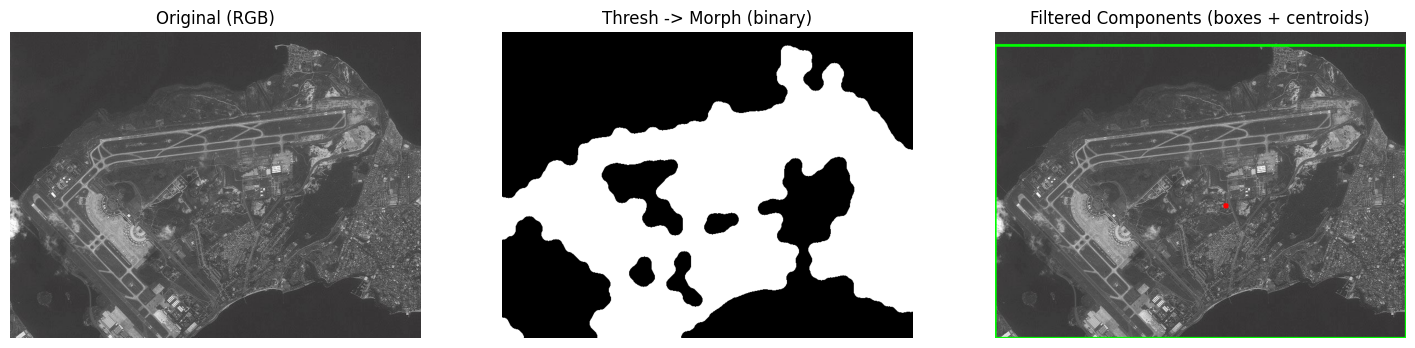

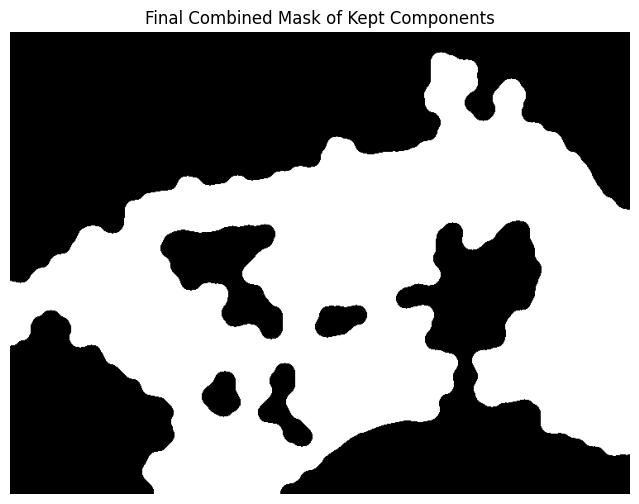

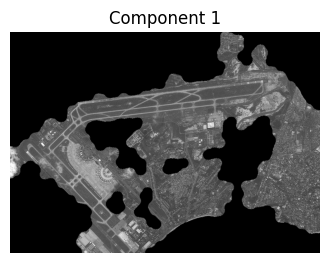

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ---------- Settings (tweak these) ----------
img_path = "galeao.jpg"
gauss_ksize = (7, 7)
morph_kernel_size = (25, 25)   # bigger kernel -> merges larger white areas (tweak)
area_min = 5000                # minimum component area to keep (tweak)
area_max = 5000000             # maximum component area to keep (tweak)
# --------------------------------------------

# Load image
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Image not found: {img_path}")

# For display with matplotlib convert BGR->RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Grayscale + blur
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, gauss_ksize, 0)

# Otsu threshold (keep white as 255)
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Morphological ops to connect runway / airport white regions and remove small noise
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, morph_kernel_size)
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)   # fills small holes
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)    # remove small isolated blobs

# Connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(opened, connectivity=8)

# Prepare outputs
mask_filtered = np.zeros_like(gray, dtype=np.uint8)   # final combined mask
out_img = img_rgb.copy()

# Collect some individual component images for display
components_to_show = []
for i in range(1, num_labels):   # skip background label 0
    area = stats[i, cv2.CC_STAT_AREA]
    if area_min <= area <= area_max:
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]

        # bounding box & centroid on color image
        cv2.rectangle(out_img, (x, y), (x + w, y + h), (0, 255, 0), 3)
        cx, cy = centroids[i]
        cv2.circle(out_img, (int(cx), int(cy)), 5, (255, 0, 0), -1)

        # build the mask for this component and add it to global mask
        comp_mask = (labels == i).astype(np.uint8) * 255
        mask_filtered = cv2.bitwise_or(mask_filtered, comp_mask)

        # save some individual components (cropped) for viewing
        comp_crop = cv2.bitwise_and(img_rgb, img_rgb, mask=comp_mask)
        comp_crop = comp_crop[y:y+h, x:x+w]
        components_to_show.append(comp_crop)

# Convert mask to RGB for display consistency
mask_rgb = cv2.cvtColor(mask_filtered, cv2.COLOR_GRAY2RGB)

# Show images inline with matplotlib
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
axes[0].imshow(img_rgb)
axes[0].set_title("Original (RGB)")
axes[0].axis("off")

axes[1].imshow(opened, cmap="gray")
axes[1].set_title("Thresh -> Morph (binary)")
axes[1].axis("off")

axes[2].imshow(out_img)
axes[2].set_title("Filtered Components (boxes + centroids)")
axes[2].axis("off")

plt.show()

# Show final combined mask and a few individual components (if any)
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 6))
ax2.imshow(mask_rgb)
ax2.set_title("Final Combined Mask of Kept Components")
ax2.axis("off")
plt.show()

# Show up to 6 individual component crops inline
n_show = min(len(components_to_show), 6)
if n_show:
    cols = n_show
    fig3, axs3 = plt.subplots(1, cols, figsize=(4*cols, 4))
    if cols == 1:
        axs3 = [axs3]
    for k in range(n_show):
        axs3[k].imshow(components_to_show[k])
        axs3[k].axis("off")
        axs3[k].set_title(f"Component {k+1}")
    plt.show()
else:
    print("No components matched the area thresholds. Try lowering 'area_min' or increasing kernel size.")
